In [189]:
!cp -r ../input/recsys-repo/RecSys_Course_AT_PoliMi-master/* ./

In [190]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from urllib.request import urlretrieve
import zipfile, os
import scipy.sparse as sps
import matplotlib.pyplot as pyplot
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout


In [191]:
URM_path = "../input/urm-updated/URM_updated.csv"

URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep=",",
                                dtype={0:int, 1:int, 2:float},
                                header=0)

URM_all_dataframe.columns = ["UserID", "ItemID", "Data"]

URM_all_dataframe.head(n=10)


,UserID,ItemID,Data
0,0,21,1.0
1,0,124,1.0
2,0,808,1.0
3,0,1326,1.0
4,0,1995,1.0
5,0,5068,1.0
6,0,7603,1.0
7,0,8540,1.0
8,0,10682,1.0
9,0,13290,1.0


In [192]:
print ("The number of interactions is {}".format(len(URM_all_dataframe)))

userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

userID_unique
itemID_unique

The number of interactions is 1051828


array([   21,   124,   808, ..., 10266, 21018, 17054])

In [193]:
n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 24507, Number of users	 41629
Max ID items	 24506, Max Id users	 41628

Average interactions per user 25.27
Average interactions per item 42.92

Sparsity 99.90 %


In [194]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe["Data"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)))

URM_all

<41629x24507 sparse matrix of type '<class 'numpy.float64'>'
	with 1051828 stored elements in COOrdinate format>

In [195]:
URM_all = sps.csr_matrix((URM_all_dataframe["Data"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)),
                        shape = (n_users, n_items))

URM_all

<41629x24507 sparse matrix of type '<class 'numpy.float64'>'
	with 1051828 stored elements in Compressed Sparse Row format>

In [196]:
item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity

array([19, 35, 26, ..., 14, 13, 12], dtype=int32)

In [197]:
item_popularity = np.sort(item_popularity)
item_popularity

array([   3,    4,    5, ..., 4676, 5366, 7382], dtype=int32)

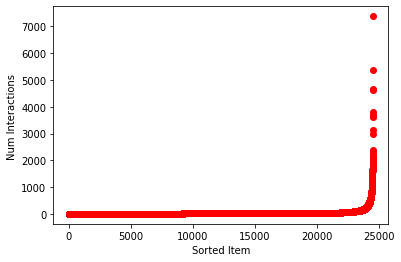

In [198]:
pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [199]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


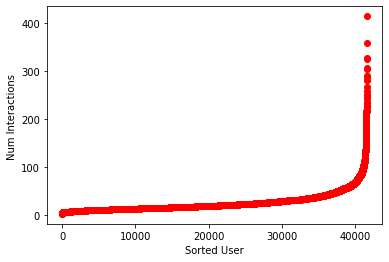

In [200]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)


pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()

In [201]:
URM_all = sps.csr_matrix((URM_all_dataframe["Data"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)),
                        shape = (n_users, n_items))

URM_all

<41629x24507 sparse matrix of type '<class 'numpy.float64'>'
	with 1051828 stored elements in Compressed Sparse Row format>

In [202]:
URM_train, URM_valid = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
evaluator_validation = EvaluatorHoldout(URM_valid, cutoff_list=[10])

EvaluatorHoldout: Ignoring 1485 ( 3.6%) Users that have less than 1 test interactions


In [203]:
def recall(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant) / relevant_items.shape[0]
    
    return recall_score
    
    
def precision(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant) / recommendations.shape[0]

    return precision_score

def MAP(recommendations: np.array, relevant_items: np.array) -> float:
    is_relevant = np.in1d(recommendations, relevant_items, assume_unique=True)
    
    precision_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    map_score = np.sum(precision_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

In [204]:
def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP)) 

In [205]:
class TopPopRecommender(object):

    def fit(self, URM_train):
        
        self.URM_train = URM_train

        item_popularity = np.ediff1d(URM_all.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            seen_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id+1]]
            
            unseen_items_mask = np.in1d(self.popular_items, seen_items, assume_unique=True, invert = True)

            unseen_items = self.popular_items[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popular_items[0:at]
            

        return recommended_items

In [206]:
topPopRecommender = TopPopRecommender()
topPopRecommender.fit(URM_all)

for user_id in range(10):
    print(topPopRecommender.recommend(user_id, at=10))

[ 22  20  56  25  23 450  53  29  58 448]
[ 21  22  20  56  25  23 450  53 124  29]
[ 21  22  56  25  23 450  53 124  29  58]
[ 21  20  25  23 450 124  29  58 448  60]
[ 21  22  20  56  23 450 124  29  58 448]
[ 21  22  20  25  23 450  53 124  29  58]
[ 21  22  20  56  25  23 450  53 124  29]
[ 21  22  20  56  23 450  53 124  29  58]
[ 21  22  20  56  25  23 450  53 124  29]
[ 21  56  25  23 450  53  29  58 448 352]


In [207]:
evaluate_algorithm(URM_valid, topPopRecommender, at=10)

Recommender results are: Precision = 0.0000, Recall = 0.0000, MAP = 0.0000


In [208]:
test_users = pd.read_csv('../input/competition-data/data_target_users_test.csv')
test_users

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
41111,41624
41112,41625
41113,41626
41114,41627


In [209]:
user_id = test_users['user_id']
recommendations = []
for user in user_id:
    recommendations.append(topPopRecommender.recommend(user,at = 10))

In [210]:
for index in range(len(recommendations)):
    recommendations[index]=np.array(recommendations[index])
    
test_users['item_list']= recommendations
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])
test_users.to_csv('submission.csv', index=False)